In [1]:
import pandas as pd
import requests
from tqdm import tqdm
tqdm.pandas() 
import matplotlib.pyplot as plt
import numpy as np

RuntimeError: CPU dispatcher tracer already initlized

In [35]:
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
random_state = 2023

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '../data/xy_train.csv'
test_path  = '../data/xy_test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

/tmp/ipykernel_956458/733229895.py:4: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  dt = pd.read_csv(train_path)


In [3]:
print(dt.shape, dt_test.shape)

(1118822, 52) (9272, 51)


In [4]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

# 좌표

In [5]:
concat[['좌표X', '좌표Y']].isnull().sum()

좌표X    876232
좌표Y    876232
dtype: int64

In [6]:
api_key = 'e4ad28c4f3024584325d8afa07e4bf8f'

In [7]:
def get_coordinates_with_fallback(region, bonbun, bubun, api_key):
    """
    주소를 단계적으로 축소해가며 좌표를 검색합니다.
    
    Parameters:
    - region (str): 행정구역 (시/도 + 구/군 + 읍/면/동)
    - bonbun (int): 본번
    - bubun (int): 부번
    - api_key (str): Kakao Maps REST API 키
    
    Returns:
    - tuple: (latitude, longitude) 또는 None (오류 시)
    """
    # 주소를 축소하는 순서대로 리스트 생성
    addresses = []
    # if bubun > 0:
    addresses.append(f"{region} {bonbun}-{bubun}")  # 본번과 부번 포함
    addresses.append(f"{region} {bonbun}")  # 본번만 포함
    addresses.append(region)  # 행정구역만 포함

    url = "https://dapi.kakao.com/v2/local/search/address.json"
    headers = {"Authorization": f"KakaoAK {api_key}"}

    for address in addresses:
        params = {"query": address}
        try:
            response = requests.get(url, headers=headers, params=params)
            response.raise_for_status()
            result = response.json()

            if result["documents"]:
                # 첫 번째 결과의 좌표 반환
                x = result["documents"][0]["x"]  # 경도
                y = result["documents"][0]["y"]  # 위도
                # print(f"주소 검색 성공: {address}")
                return float(y), float(x)
            else:
                # print(f"주소를 찾을 수 없습니다: {address}")
                pass

        except requests.exceptions.HTTPError as e:
            print(f"HTTP 오류 발생: {e}")
        except Exception as e:
            print(f"기타 오류 발생: {e}")
    
    # 모든 시도가 실패하면 None 반환
    return None

In [8]:
unique_addresses = concat[['시군구', '본번', '부번']].drop_duplicates()
unique_addresses

,시군구,본번,부번
0,서울특별시 강남구 개포동,658.0,1.0
12,서울특별시 강남구 개포동,652.0,0.0
25,서울특별시 강남구 개포동,12.0,2.0
38,서울특별시 강남구 개포동,141.0,0.0
204,서울특별시 강남구 개포동,187.0,0.0
...,...,...,...
4581,서울특별시 동작구 흑석동,253.0,89.0
4738,서울특별시 마포구 신수동,400.0,1.0
6087,서울특별시 성동구 송정동,67.0,5.0
8880,서울특별시 중구 인현동2가,240.0,0.0


In [9]:
unique_addresses['coordinates'] = unique_addresses.progress_apply(
    lambda row: get_coordinates_with_fallback(row['시군구'], row['본번'], row['부번'], api_key=api_key), axis=1
)

100%|██████████| 8955/8955 [12:47<00:00, 11.67it/s]


In [10]:
# 원본 데이터와 병합
concat = concat.merge(unique_addresses, on=['시군구', '본번', '부번'], how='left')
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,coordinates
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,"(37.4819251305595, 127.057440206035)"
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0,"(37.4819251305595, 127.057440206035)"
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0,"(37.4819251305595, 127.057440206035)"
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0,"(37.4819251305595, 127.057440206035)"
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0,"(37.4819251305595, 127.057440206035)"


In [11]:
concat['좌표Y'] = concat['coordinates'].astype('str').str.split(',', expand=True)[0].str.split('(', expand=True)[1].astype('float')
concat['좌표X'] = concat['coordinates'].astype('str').str.split(',', expand=True)[1].str.split(')', expand=True)[0].astype('float')
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,coordinates
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05744,37.481925,2022-11-17 10:19:06.0,124000.0,0,"(37.4819251305595, 127.057440206035)"
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05744,37.481925,2022-11-17 10:19:06.0,123500.0,0,"(37.4819251305595, 127.057440206035)"
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05744,37.481925,2022-11-17 10:19:06.0,91500.0,0,"(37.4819251305595, 127.057440206035)"
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05744,37.481925,2022-11-17 10:19:06.0,130000.0,0,"(37.4819251305595, 127.057440206035)"
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,임의,2022-11-17 13:00:29.0,Y,N,127.05744,37.481925,2022-11-17 10:19:06.0,117000.0,0,"(37.4819251305595, 127.057440206035)"


In [12]:
concat.drop(columns=['coordinates'], axis=1, inplace=True)

In [13]:
concat[['좌표X', '좌표Y']].isnull().sum()

좌표X    0
좌표Y    0
dtype: int64

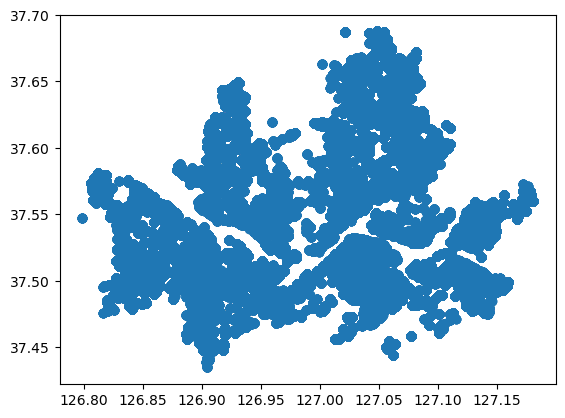

In [16]:
plt.scatter(concat['좌표X'], concat['좌표Y'])

# 지하철 거리

In [5]:
subway_path = "../data/subway_feature.csv"
subway_data = pd.read_csv(subway_path)

In [6]:
from math import radians, sin, cos, sqrt, atan2
from scipy.spatial import KDTree

apartment_coords = concat[['좌표Y', '좌표X']].values
station_coords = subway_data[['위도', '경도']].values

def latlon_to_cartesian(lat, lon):
    R = 6371.0  # 지구 반지름 (km)
    lat, lon = radians(lat), radians(lon)
    x = R * cos(lat) * cos(lon)
    y = R * cos(lat) * sin(lon)
    z = R * sin(lat)
    return x, y, z

apartment_cartesian = np.array([latlon_to_cartesian(lat, lon) for lat, lon in apartment_coords])
station_cartesian = np.array([latlon_to_cartesian(lat, lon) for lat, lon in station_coords])

station_tree = KDTree(station_cartesian)
nearest_distances, nearest_station_indices = station_tree.query(apartment_cartesian, k=1)

concat['근처지하철역'] = [subway_data.iloc[i]['역사명'] for i in nearest_station_indices]
concat['지하철거리'] = nearest_distances

concat[['근처지하철역', '지하철거리']].head()


,근처지하철역,지하철거리
0,구룡,0.560496
1,구룡,0.560496
2,구룡,0.560496
3,구룡,0.560496
4,구룡,0.560496


In [140]:
concat.tail()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,target,is_test,근처지하철역,지하철거리,근처학교수,중학교 점수,고등학교 점수,학군 점수,근처학교,학교거리
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,NaN,1,신내,0.591316,1309,345,213,558,대광중학교,0.591316
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,NaN,1,신내,0.591316,1309,345,213,558,대광중학교,0.591316
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,NaN,1,신내,0.591316,1309,345,213,558,대광중학교,0.591316
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,NaN,1,신내,0.591316,1309,345,213,558,대광중학교,0.591316
9271,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202309,4,13,2014,...,NaN,1,신내,0.591316,1309,345,213,558,대광중학교,0.591316


In [10]:
concat['좌표Y'].isnull().sum()

0

# 학교

In [18]:
school_path = "../data/school_data.csv"
school_data = pd.read_csv(school_path)


In [137]:
school_data

,Unnamed: 0,학교ID,학교명,학교급구분,설립일자,설립형태,본교분교구분,운영상태,소재지지번주소,소재지도로명주소,...,시도교육청명,교육지원청코드,교육지원청명,생성일자,변경일자,위도,경도,데이터기준일자,제공기관코드,제공기관명
0,2,B000008404,미성중학교,중학교,1984-05-17,공립,본교,운영,서울특별시 관악구 신림동 745-24,서울특별시 관악구 문성로16길 40,...,서울특별시교육청,7132000,서울특별시동작관악교육지원청,2013-11-29,2024-07-09,37.475383,126.912089,2024-09-20,B555223,재단법인한국지방교육행정연구재단
1,22,B000008246,장충중학교,중학교,1947-08-25,사립,본교,운영,서울특별시 중구 신당동 432-460,서울특별시 중구 동호로15길 93,...,서울특별시교육청,7061000,서울특별시중부교육지원청,2013-11-29,2024-07-09,37.553515,127.006415,2024-09-20,B555223,재단법인한국지방교육행정연구재단
2,35,B000011324,선정국제관광고등학교,고등학교,1950-05-22,사립,본교,운영,서울특별시 은평구 갈현동 227-5,서울특별시 은평구 서오릉로20길 19,...,서울특별시교육청,7031000,서울특별시서부교육지원청,2013-11-29,2024-07-09,37.618705,126.909032,2024-09-20,B555223,재단법인한국지방교육행정연구재단
3,40,B000002431,영훈초등학교,초등학교,1965-09-25,사립,본교,운영,서울특별시 강북구 미아동 471-2,서울특별시 강북구 도봉로13가길 19,...,서울특별시교육청,7121200,서울특별시성북강북교육지원청,2013-11-29,2024-07-09,37.614682,127.028093,2024-09-20,B555223,재단법인한국지방교육행정연구재단
4,44,B000008357,대왕중학교,중학교,1994-05-06,공립,본교,운영,서울특별시 강남구 수서동 750,서울특별시 강남구 광평로20길 7,...,서울특별시교육청,7091300,서울특별시강남서초교육지원청,2013-11-29,2024-07-09,37.483460,127.087338,2024-09-20,B555223,재단법인한국지방교육행정연구재단
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,11841,B000001904,서울응암초등학교,초등학교,1962-11-12,공립,본교,운영,서울특별시 은평구 응암동 340,서울특별시 은평구 가좌로6길 20,...,서울특별시교육청,7031000,서울특별시서부교육지원청,2013-11-29,2024-07-09,37.588753,126.921616,2024-09-20,B555223,재단법인한국지방교육행정연구재단
1305,11930,B000026183,서울항동초등학교,초등학교,2019-05-01,공립,본교,운영,서울특별시 구로구 항동 160,서울특별시 구로구 연동로 178,...,서울특별시교육청,7041000,서울특별시남부교육지원청,2013-11-29,2024-07-09,37.477016,126.824110,2024-09-20,B555223,재단법인한국지방교육행정연구재단
1306,11942,B000002124,서울가락초등학교,초등학교,1981-09-09,공립,본교,운영,서울특별시 송파구 가락동 477,서울특별시 송파구 송파대로37길 45,...,서울특별시교육청,7130000,서울특별시강동송파교육지원청,2013-11-29,2024-07-09,37.500021,127.107642,2024-09-20,B555223,재단법인한국지방교육행정연구재단
1307,11948,B000025614,서울하늘숲초등학교,초등학교,2019-03-01,공립,본교,운영,서울특별시 구로구 천왕동 산13-1,서울특별시 구로구 오리로 1106,...,서울특별시교육청,7041000,서울특별시남부교육지원청,2013-11-29,2024-07-09,37.484181,126.841652,2024-09-20,B555223,재단법인한국지방교육행정연구재단


In [31]:
school_coords = np.array(school_data[['위도', '경도']].values)

apartment_coords = np.array(concat[['좌표Y', '좌표X']].values)

school_tree = KDTree(school_coords)

nearby_school_counts = []
radius = 0.5  # 반경 1km (단위: km)

for apartment in apartment_coords:
    indices = school_tree.query_ball_point(apartment, r=radius)
    nearby_school_counts.append(len(indices))

In [33]:
concat['근처학교수'] = nearby_school_counts

In [27]:
concat['근처학교수'].value_counts()

1309    1128094
Name: 근처학교수, dtype: int64

In [26]:
print(concat[['좌표Y', '좌표X', '근처학교수']].head())

         좌표Y        좌표X  근처학교수
0  37.481925  127.05744   1309
1  37.481925  127.05744   1309
2  37.481925  127.05744   1309
3  37.481925  127.05744   1309
4  37.481925  127.05744   1309


In [28]:
print(school_data[['위도', '경도']].drop_duplicates().head(10))  # 중복 좌표 확인
print(school_data[['위도', '경도']].describe())  # 좌표 범위 확인


          위도          경도
0  37.475383  126.912089
1  37.553515  127.006415
2  37.618705  126.909032
3  37.614682  127.028093
4  37.483460  127.087338
5  37.585676  127.070042
6  37.485576  126.949391
7  37.566411  126.911775
8  37.585736  127.058214
9  37.548369  126.868717
                위도           경도
count  1309.000000  1309.000000
mean     37.552951   126.993854
std       0.055203     0.091823
min      37.441443   126.804646
25%      37.505289   126.916967
50%      37.549876   127.011443
75%      37.592309   127.065027
max      37.687233   127.180267


In [ ]:
# concat = concat.drop(['근처학교수'], axis=1)

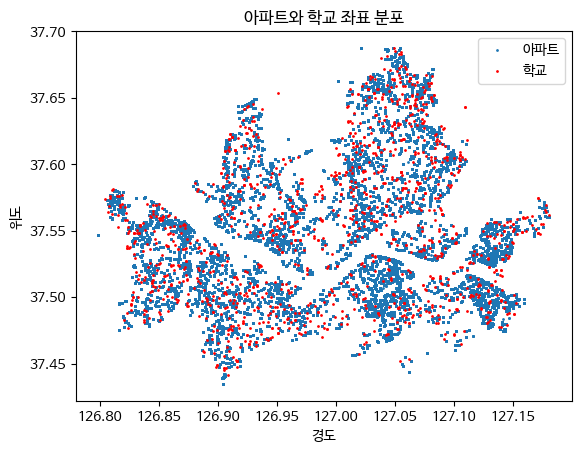

In [36]:
import matplotlib.pyplot as plt

# 아파트와 학교 좌표 시각화
plt.scatter(apartment_coords[:, 1], apartment_coords[:, 0], s=1, label='아파트')
plt.scatter(school_coords[:, 1], school_coords[:, 0], s=1, label='학교', color='red')
plt.legend()
plt.title('아파트와 학교 좌표 분포')
plt.xlabel('경도')
plt.ylabel('위도')
plt.show()


# 학군

In [46]:
middleschool_path = "../data/seoul_middle_school_with_coords.csv"
highschool_path = "../data/seoul_high_school_with_coords.csv"
middleschool_data = pd.read_csv(middleschool_path)
highschool_data = pd.read_csv(highschool_path)

print(middleschool_data)
print(highschool_data)

      순위         위치      학교명         위도          경도
0      1    광진구 중곡동  대원국제중학교  37.562493  127.089418
1      2    강북구 미아동  영훈국제중학교  37.614682  127.028093
2      3    강남구 수서동    대왕중학교  37.483460  127.087338
3      4    광진구 광장동    광남중학교  37.540830  127.101621
4      5  강남구 압구정1동   압구정중학교  37.530242  127.033003
..   ...        ...      ...        ...         ...
376  378    은평구 응암동    충암중학교  37.584640  126.921809
377  379    중랑구 망우동    동원중학교  37.603807  127.109498
378  380    양천구 신월동    신원중학교  37.537092  126.824842
379  381    양천구 신월동    양서중학교  37.532629  126.829135
380  382    송파구 방이동  서울체육중학교  37.522330  127.129823

[381 rows x 5 columns]
      순위        위치         학교명         위도          경도
0      1  서대문구 현저동    한성과학고등학교  37.575436  126.952371
1      2   광진구 중곡동   대원외국어고등학교  37.562493  127.089437
2      3   서초구 반포동      세화고등학교  37.501996  126.994230
3      4   은평구 진관동      하나고등학교  37.641638  126.936930
4      5  강서구 내발산동   명덕외국어고등학교  37.553944  126.834292
..   ...       ...         .

In [47]:
middleschool_data.isnull().sum()

순위     0
위치     0
학교명    0
위도     0
경도     0
dtype: int64

In [48]:
# 중학교 등급 생성
middleschool_data['등급'] = pd.qcut(
    middleschool_data['순위'],  # 순위 기준으로 나눔
    q=[0, 0.1, 0.3, 0.5, 1.0],  # 분위수 기준: 상위 10%, 30%, 50%, 100%
    labels=['A', 'B', 'C', 'D']  # 등급 레이블
)

# 고등학교 등급 생성
highschool_data['등급'] = pd.qcut(
    highschool_data['순위'],  # 순위 기준으로 나눔
    q=[0, 0.1, 0.3, 0.5, 1.0],  # 분위수 기준
    labels=['A', 'B', 'C', 'D']  # 등급 레이블
)

# 등급 확인
print(middleschool_data[['학교명', '순위', '등급']].head())
print(highschool_data[['학교명', '순위', '등급']].head())


       학교명  순위 등급
0  대원국제중학교   1  A
1  영훈국제중학교   2  A
2    대왕중학교   3  A
3    광남중학교   4  A
4   압구정중학교   5  A
         학교명  순위 등급
0   한성과학고등학교   1  A
1  대원외국어고등학교   2  A
2     세화고등학교   3  A
3     하나고등학교   4  A
4  명덕외국어고등학교   5  A


In [49]:
# 중학교와 고등학교 등급 점수화
middleschool_data['등급 점수'] = middleschool_data['등급'].map({'A': 3, 'B': 2, 'C': 1, 'D': 0})
highschool_data['등급 점수'] = highschool_data['등급'].map({'A': 3, 'B': 2, 'C': 1, 'D': 0})

# 등급 점수 확인
print(middleschool_data[['학교명', '순위', '등급', '등급 점수']].head())
print(highschool_data[['학교명', '순위', '등급', '등급 점수']].head())


       학교명  순위 등급 등급 점수
0  대원국제중학교   1  A     3
1  영훈국제중학교   2  A     3
2    대왕중학교   3  A     3
3    광남중학교   4  A     3
4   압구정중학교   5  A     3
         학교명  순위 등급 등급 점수
0   한성과학고등학교   1  A     3
1  대원외국어고등학교   2  A     3
2     세화고등학교   3  A     3
3     하나고등학교   4  A     3
4  명덕외국어고등학교   5  A     3


In [50]:
# 중학교 좌표에서 결측값 여부 확인
print(middleschool_data[['위도', '경도']].isnull().sum())  # NaN 개수 확인
print(middleschool_data[['위도', '경도']].describe())     # 값 범위 확인


위도    0
경도    0
dtype: int64
               위도          경도
count  381.000000  381.000000
mean    37.554006  126.995037
std      0.054501    0.090222
min     37.446295  126.807107
25%     37.507364  126.921809
50%     37.548698  127.010484
75%     37.592735  127.062393
max     37.683145  127.177836


In [54]:
# 중학교와 고등학교의 등급 점수를 숫자형으로 변환
middleschool_data['등급 점수'] = middleschool_data['등급 점수'].astype(int)
highschool_data['등급 점수'] = highschool_data['등급 점수'].astype(int)


In [ ]:
# from scipy.spatial import KDTree
# import numpy as np

# # 중학교와 고등학교 좌표
# middle_coords = np.array(middleschool_data[['위도', '경도']].values)
# high_coords = np.array(highschool_data[['위도', '경도']].values)

# # KDTree 생성
# middle_tree = KDTree(middle_coords)
# high_tree = KDTree(high_coords)

# # 아파트 좌표
# apartment_coords = np.array(concat[['좌표Y', '좌표X']].values)

# # 반경 내 학군 점수 계산
# radius = 1.0  # 반경 1km
# middle_scores = []
# high_scores = []

# for apartment in apartment_coords:
#     # 중학교 점수 계산
#     middle_indices = middle_tree.query_ball_point(apartment, r=radius)
#     middle_score = middleschool_data.iloc[middle_indices]['등급 점수'].sum()
#     middle_scores.append(middle_score)
    
#     # 고등학교 점수 계산
#     high_indices = high_tree.query_ball_point(apartment, r=radius)
#     high_score = highschool_data.iloc[high_indices]['등급 점수'].sum()
#     high_scores.append(high_score)

# # 학군 점수 합산
# concat['중학교 점수'] = middle_scores
# concat['고등학교 점수'] = high_scores
# concat['학군 점수'] = concat['중학교 점수'] + concat['고등학교 점수']


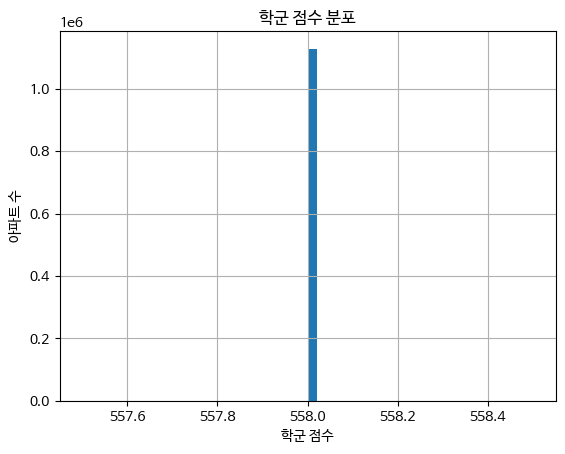

In [56]:
# # 학군 점수 분포 확인
# concat['학군 점수'].hist(bins=50)
# plt.title('학군 점수 분포')
# plt.xlabel('학군 점수')
# plt.ylabel('아파트 수')
# plt.show()


In [ ]:
# 학군 점수와 아파트 가격 상관관계
correlation = concat[['학군 점수', '아파트 가격']].corr()
print(correlation)


In [57]:
# 중학교와 고등학교 데이터 병합
combined_data = pd.concat([middleschool_data, highschool_data])

# A 등급인 학교 필터링
a_grade_schools = combined_data[combined_data['등급'] == 'A']

# 결과 확인
print(a_grade_schools[['학교명', '순위', '등급', '등급 점수']].head())


       학교명  순위 등급  등급 점수
0  대원국제중학교   1  A      3
1  영훈국제중학교   2  A      3
2    대왕중학교   3  A      3
3    광남중학교   4  A      3
4   압구정중학교   5  A      3


In [115]:
combined_data['구'] = combined_data['위치'].apply(lambda x: x.split(' ')[0] if pd.notna(x) else None)
combined_data['동'] = combined_data['위치'].apply(lambda x: x.split(' ')[1] if pd.notna(x) else None)

print(combined_data[['위치', '구', '동']].head())


          위치    구      동
0    광진구 중곡동  광진구    중곡동
1    강북구 미아동  강북구    미아동
2    강남구 수서동  강남구    수서동
3    광진구 광장동  광진구    광장동
4  강남구 압구정1동  강남구  압구정1동


In [136]:
# '동'이 포함되지 않은 행 필터링
no_dong_data = combined_data[~combined_data['위치'].str.contains(r'동', regex=True)]

print(no_dong_data)


      순위          위치       학교명         위도          경도 등급  등급 점수     구      동
45    46   용산구 원효로4가   성심여자중학교  37.534209  126.954593  B      2   용산구  원효로4가
217  218  서대문구 충정로2가     인창중학교  37.564885  126.964023  D      0  서대문구  충정로2가
11    12    종로구 명륜1가  서울국제고등학교  37.591791  126.995491  A      3   종로구   명륜1가
55    56   용산구 원효로4가  성심여자고등학교  37.534209  126.954593  B      2   용산구  원효로4가
161  162  서대문구 충정로2가    인창고등학교  37.564885  126.964023  D      0  서대문구  충정로2가


In [135]:
# 숫자나 '가'가 포함된 행 필터링
filtered_data = combined_data[combined_data['위치'].str.contains(r'\d+|가', regex=True)]

print(filtered_data)


      순위          위치      학교명         위도          경도 등급  등급 점수     구      동
4      5   강남구 압구정1동   압구정중학교  37.530242  127.033003  A      3   강남구  압구정1동
19    20    양천구 신정7동  봉영여자중학교  37.509216  126.860198  A      3   양천구   신정7동
27    28    송파구 잠실2동    잠신중학교  37.516139  127.087802  A      3   송파구   잠실2동
35    36    노원구 중계1동    을지중학교  37.649788  127.071708  A      3   노원구   중계1동
45    46   용산구 원효로4가  성심여자중학교  37.534209  126.954593  B      2   용산구  원효로4가
..   ...         ...      ...        ...         ... ..    ...   ...    ...
204  206   성동구 성수동1가   성수고등학교  37.547342  127.038253  D      0   성동구  성수동1가
210  212    광진구 중곡4동   대원고등학교  37.562493  127.089437  D      0   광진구   중곡4동
212  214   성북구 삼선동3가   경동고등학교  37.586698  127.016321  D      0   성북구  삼선동3가
221  223  동대문구 청량리1동   청량고등학교  37.588886  127.051311  D      0  동대문구  청량리1동
228  230   서대문구 북가좌동  가재울고등학교  37.574446  126.909415  D      0  서대문구   북가좌동

[72 rows x 9 columns]


In [ ]:
dong_names = [re.sub(r'\d+', '', dong) for dong in combined_data['동']]

dong_list = combined_data['동'].value_counts()
print(dong_list)

In [131]:
import re

# dong_list.index에서 숫자를 제거하고 동 이름만 남기기
dong_names = [re.sub(r'\d+', '', dong) for dong in combined_data['동']]
print(dong_names)


['중곡동', '미아동', '수서동', '광장동', '압구정동', '방이동', '대치동', '목동', '목동', '서초동', '대치동', '목동', '압구정동', '신천동', '대치동', '역삼동', '홍지동', '도곡동', '개포동', '신정동', '반포동', '반포동', '서초동', '대방동', '역삼동', '광장동', '신정동', '잠실동', '창동', '반포동', '삼성동', '잠실동', '잠원동', '내발산동', '도곡동', '중계동', '방배동', '잠원동', '반포동', '쌍문동', '이촌동', '염리동', '삼성동', '목동', '서초동', '원효로가', '중계동', '천연동', '고덕동', '역삼동', '신도림동', '여의도동', '반포동', '성북동', '하계동', '돈암동', '신대방동', '도곡동', '염창동', '가락동', '도곡동', '당산동가', '돈암동', '길음동', '방이동', '진관동', '방배동', '중계동', '가양동', '잠실동', '방이동', '상일동', '내발산동', '필운동', '하계동', '신정동', '개포동', '송파동', '내발산동', '상암동', '공릉동', '암사동', '묵동', '대신동', '중동', '가락동', '회기동', '휘경동', '상계동', '염창동', '응봉동', '상계동', '신정동', '장지동', '청담동', '상계동', '홍은동', '북가좌동', '동작동', '상계동', '잠실동', '상도동', '상계동', '여의도동', '대흥동', '일원동', '자곡동', '청운동', '방학동', '진관동', '미아동', '동숭동', '쌍문동', '문래동가', '삼선동가', '사당동', '문정동', '신당동', '신정동', '창동', '서빙고동', '대방동', '돈암동', '논현동', '하계동', '당산동가', '신수동', '가락동', '월계동', '염리동', '천호동', '상계동', '방화동', '방학동', '신사동', '풍납동', '봉천동', '동소문동가', '성수동가', '오류동', '풍납동', '

상계동      15
봉천동      13
신림동      12
중계동      10
미아동      10
         ..
정릉3동      1
본동        1
길동        1
흑석동       1
청량리1동     1
Name: 동, Length: 209, dtype: int64


In [124]:
# 구별 등급 개수 계산
grade_counts_by_gu = combined_data.groupby(['동', '등급']).size().reset_index(name='개수')

# 등급별 개수를 기준으로 정렬
grade_ranked = grade_counts_by_gu.sort_values(by=['등급', '개수'], ascending=[True, False])

# 결과 확인
print(grade_ranked)


       동 등급  개수
256  반포동  A   6
224   목동  A   5
140  대치동  A   3
148  도곡동  A   3
52   광장동  A   2
..   ... ..  ..
771  필운동  D   0
775  하계동  D   0
795  현저동  D   0
815  홍지동  D   0
835  흑석동  D   0

[836 rows x 3 columns]


In [125]:
# 등급별 상위 N개 동 추출 (예: 상위 5개)
top_n = grade_ranked.groupby('등급').head(5)

# 결과 확인
print(top_n)

        동 등급  개수
256   반포동  A   6
224    목동  A   5
140   대치동  A   3
148   도곡동  A   3
52    광장동  A   2
337   상계동  B   6
97   내발산동  B   4
269   방이동  B   4
685   중계동  B   4
149   도곡동  B   3
430   신당동  C   5
294   봉천동  C   4
338   상계동  C   4
766   풍납동  C   4
190   등촌동  C   3
447   신림동  D  10
295   봉천동  D   8
255   미아동  D   7
471   신월동  D   7
163   독산동  D   6


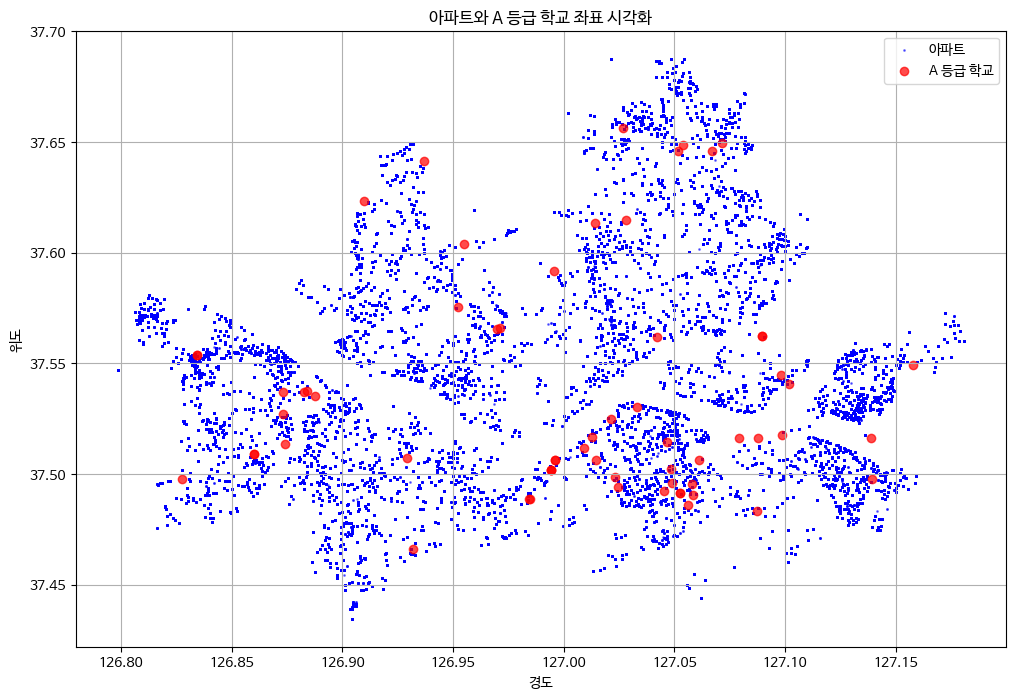

In [64]:
import matplotlib.pyplot as plt

# 아파트 좌표 추출
apartment_lat = concat['좌표Y']
apartment_lon = concat['좌표X']

# A 등급 학교 좌표 추출
latitude = a_grade_schools['위도']
longitude = a_grade_schools['경도']

# 시각화
plt.figure(figsize=(12, 8))

# 아파트 좌표 플롯
plt.scatter(apartment_lon, apartment_lat, s=1, label='아파트', alpha=0.5, color='blue')

# A 등급 학교 좌표 플롯
plt.scatter(longitude, latitude, c='red', label='A 등급 학교', alpha=0.7)

# 제목 및 레이블
plt.title('아파트와 A 등급 학교 좌표 시각화')
plt.xlabel('경도')
plt.ylabel('위도')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


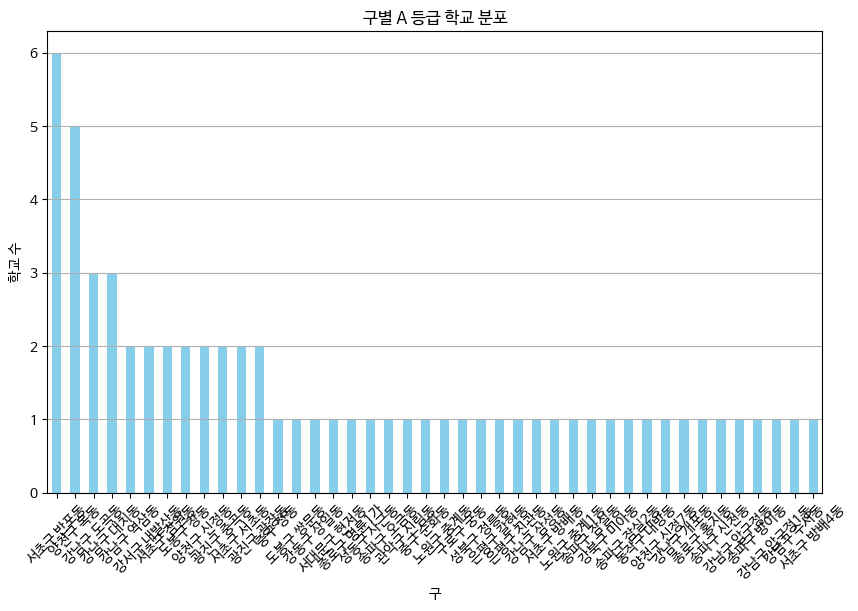

In [63]:
# 구별 A 등급 학교 개수 집계
district_counts = a_grade_schools['위치'].value_counts()

# 히스토그램 그리기
district_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('구별 A 등급 학교 분포')
plt.xlabel('구')
plt.ylabel('학교 수')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [146]:
school_coords = np.array(combined_data[['위도', '경도']].values)
apartment_coords = np.array(concat[['좌표Y', '좌표X']].values)

In [147]:
apartment_cartesian = np.array([latlon_to_cartesian(lat, lon) for lat, lon in apartment_coords])
school_cartesian = np.array([latlon_to_cartesian(lat, lon) for lat, lon in school_coords])

school_tree = KDTree(school_cartesian)
nearest_distances, nearest_school_indices = school_tree.query(apartment_cartesian, k=1)

concat['근처학교'] = [combined_data.iloc[i]['학교명'] for i in nearest_school_indices]
concat['학교거리'] = nearest_distances



In [148]:
concat[['근처학교', '학교거리']].value_counts()

근처학교   학교거리    
서운중학교  0.615879    8891
이수중학교  0.512362    7273
원촌중학교  0.176673    6598
장평중학교  0.326666    6590
화원중학교  0.576384    5324
                   ... 
구의중학교  0.504711       1
언남중학교  0.115534       1
방배중학교  0.506361       1
언북중학교  0.955498       1
신수중학교  0.926666       1
Length: 4326, dtype: int64

In [152]:
combined_data[['학교명', '등급']]

,학교명,등급
0,대원국제중학교,A
1,영훈국제중학교,A
2,대왕중학교,A
3,광남중학교,A
4,압구정중학교,A
...,...,...
231,선사고등학교,D
232,영신고등학교,D
233,신서고등학교,D
234,서울공연예술고등학교,D


In [149]:
concat

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,target,is_test,근처지하철역,지하철거리,근처학교수,중학교 점수,고등학교 점수,학군 점수,근처학교,학교거리
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,124000.0,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,123500.0,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,91500.0,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,130000.0,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,117000.0,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,NaN,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,NaN,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,NaN,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,NaN,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117


In [154]:
concat['등급'] = concat['근처학교'].map(
    combined_data.set_index('학교명')['등급']
)

concat['등급']



,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,is_test,근처지하철역,지하철거리,근처학교수,중학교 점수,고등학교 점수,학군 점수,근처학교,학교거리,등급
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758,C
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758,C
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758,C
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758,C
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,0,구룡,0.560496,1309,345,213,558,개포고등학교,0.378758,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9267,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.65,202307,19,13,2014,...,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117,D
9268,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.62,202307,25,12,2014,...,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117,D
9269,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,101.65,202308,27,12,2014,...,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117,D
9270,서울특별시 중랑구 신내동,816,816.0,0.0,신내우디안1단지,84.94,202309,2,18,2014,...,1,신내,0.591316,1309,345,213,558,송곡여자고등학교,1.197117,D


In [156]:
# 등급이 'A'인 데이터 필터링
a_school_data = concat[concat['등급'] == 'A']

# 결과 출력
a_school_data

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,is_test,근처지하철역,지하철거리,근처학교수,중학교 점수,고등학교 점수,학군 점수,근처학교,학교거리,등급
12,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.4600,201710,13,1,1984,...,0,구룡,0.405497,1309,345,213,558,구룡중학교,0.242513,A
13,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,201711,11,8,1984,...,0,구룡,0.405497,1309,345,213,558,구룡중학교,0.242513,A
14,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,201711,27,8,1984,...,0,구룡,0.405497,1309,345,213,558,구룡중학교,0.242513,A
15,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,161.0000,201712,13,6,1984,...,0,구룡,0.405497,1309,345,213,558,구룡중학교,0.242513,A
16,서울특별시 강남구 개포동,652,652.0,0.0,개포우성3차,133.4600,201712,16,10,1984,...,0,구룡,0.405497,1309,345,213,558,구룡중학교,0.242513,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,서울특별시 종로구 평창동,145-5,145.0,5.0,일성빌라트,84.9900,202308,4,4,1996,...,1,홍제,2.901207,1309,345,213,558,상명대학교사범대학부속여자중학교,1.190057,A
8963,서울특별시 중구 순화동,217,217.0,0.0,덕수궁롯데캐슬,56.2897,202307,5,11,2016,...,1,서대문,0.408596,1309,345,213,558,이화여자외국어고등학교,0.230002,A
8964,서울특별시 중구 순화동,217,217.0,0.0,덕수궁롯데캐슬,56.2897,202308,19,8,2016,...,1,서대문,0.408596,1309,345,213,558,이화여자외국어고등학교,0.230002,A
8965,서울특별시 중구 순화동,215,215.0,0.0,바비엥3,65.7100,202309,4,14,2006,...,1,서대문,0.394287,1309,345,213,558,이화여자외국어고등학교,0.269603,A


# 백화점

In [75]:
commercial_district_path = "../data/commercial_district.csv"
commercial_district_path  = pd.read_csv(commercial_district_path)
commercial_district_path.head()

,개방자치단체코드,관리번호,인허가일자,인허가취소일자,영업상태코드,영업상태명,상세영업상태코드,상세영업상태명,폐업일자,휴업시작일자,...,도로명주소,도로명우편번호,사업장명,최종수정일자,데이터갱신구분,데이터갱신일자,업태구분명,좌표정보(X),좌표정보(Y),점포구분명
0,3170000,2.013317e+18,2013-09-06,NaN,1,영업/정상,1,정상영업,NaN,NaN,...,서울특별시 금천구 디지털로 185 (가산동),153-801,마리오아울렛 1관,2023-02-28 20:56:47,U,2022-12-03 0:03:00,쇼핑센터,189943.2343,441784.2475,NaN
1,3170000,2.012317e+18,2012-09-13,NaN,1,영업/정상,1,정상영업,NaN,NaN,...,서울특별시 금천구 벚꽃로 266 (가산동),NaN,마리오아울렛 3관,2023-02-28 21:05:56,U,2022-12-03 0:03:00,쇼핑센터,189759.7131,441814.1159,NaN
2,3140000,2.012314e+18,2012-04-05,NaN,1,영업/정상,1,정상영업,NaN,NaN,...,"서울특별시 양천구 목동서로 100, 105호 (목동,목동3단지아파트 관리동상가)",NaN,롯데슈퍼 목동2점,2024-12-11 13:05:57,U,2023-11-01 23:03:00,구분없음,188700.8512,448020.0910,NaN
3,3180000,2.001318e+18,1999-05-31,NaN,1,영업/정상,1,정상영업,NaN,NaN,...,서울특별시 영등포구 영등포로 109 (당산동2가),150-723,영등포유통상가,2023-03-09 15:28:54,U,2022-12-02 23:01:00,그 밖의 대규모점포,190555.7690,446698.8143,NaN
4,3240000,2.024324e+18,2024-11-11,NaN,1,영업/정상,5,영업개시전,NaN,NaN,...,"서울특별시 강동구 풍성로38길 9, 바로빌딩 1층 (성내동)",5393,GS THE FRESH 강동성내점,2024-11-11 21:10:06,I,2023-10-31 23:03:00,구분없음,211027.5118,447708.2206,NaN


In [76]:
commercial_district_path[['도로명주소', '업태구분명']]

,도로명주소,업태구분명
0,서울특별시 금천구 디지털로 185 (가산동),쇼핑센터
1,서울특별시 금천구 벚꽃로 266 (가산동),쇼핑센터
2,"서울특별시 양천구 목동서로 100, 105호 (목동,목동3단지아파트 관리동상가)",구분없음
3,서울특별시 영등포구 영등포로 109 (당산동2가),그 밖의 대규모점포
4,"서울특별시 강동구 풍성로38길 9, 바로빌딩 1층 (성내동)",구분없음
...,...,...
1012,서울특별시 광진구 능동로 92 (자양동),백화점
1013,서울특별시 광진구 광나루로56길 85 (구의동),대형마트
1014,서울특별시 성북구 오패산로4길 17 (하월곡동),구분없음
1015,서울특별시 성북구 월계로40길 7 (장위동),구분없음


In [96]:
filtered_data = commercial_district_path[
    commercial_district_path['사업장명'].str.contains(
        '갤러리아|롯데|신세계|현대', case=False, na=False
    ) & commercial_district_path['사업장명'].str.contains('백화점', case=False, na=False)
]

print(filtered_data.shape)

filtered_data[['지번주소', '도로명주소', '사업장명', '좌표정보(X)',	'좌표정보(Y)']]

(25, 26)


,지번주소,도로명주소,사업장명,좌표정보(X),좌표정보(Y)
6,서울특별시 강남구 압구정동 515호,"서울특별시 강남구 압구정로 407 (압구정동, 갤러리아백화점)",갤러리아백화점(동관),203604.7617,447316.2228
10,서울특별시 강남구 압구정동 494호,"서울특별시 강남구 압구정로 343 (압구정동, 갤러리아백화점)",갤러리아백화점(서관),203470.8484,447369.5799
22,서울특별시 강남구 삼성동 159번지 7호,"서울특별시 강남구 테헤란로 517 (삼성동, 무역센터현대백화점)",현대백화점 무역센터점,205210.3588,445154.4223
25,서울특별시 서초구 반포동 19번지 3호,서울특별시 서초구 신반포로 176 (반포동),신세계백화점 강남점,200250.4478,444683.2205
56,서울특별시 노원구 상계동 713호,서울특별시 노원구 동일로 1414 (상계동),롯데백화점 노원점,205320.2848,461419.8818
140,서울특별시 영등포구 영등포동 618-496,서울특별시 영등포구 경인로 846 (영등포동),롯데백화점 영등포점,191741.3458,445970.3076
296,서울특별시 강남구 대치동 937호,서울특별시 강남구 도곡로 401 (대치동),롯데백화점(강남점),204669.5434,443873.6212
379,서울특별시 동대문구 전농동 620번지 69호,"서울특별시 동대문구 왕산로 205-0 (전농동, 롯데백화점(청량리점))",롯데백화점 청량리플라자,203996.0139,453058.6658
422,서울특별시 성북구 길음동 20번지 1호,"서울특별시 성북구 동소문로 315 (길음동, 현대백화점미아점)",현대백화점 미아점,202466.8011,456227.5717
435,서울특별시 성북구 길음동 25번지 2호,NaN,신세계백화점 미아점,202555.3009,456503.0662


In [113]:
def extract_gu_dong(row):
    if pd.notna(row['도로명주소']):
        gu = row['도로명주소'].split(' ')[1]
        dong = row['도로명주소'].split('(')[-1].split(')')[0][:3]
        return gu, dong
    elif pd.notna(row['지번주소']):
        gu = row['지번주소'].split(' ')[1]
        dong = row['지번주소'].split(' ')[2]
        return gu, dong
    else:
        return None, None

filtered_data[['구', '동']] = filtered_data.apply(lambda row: pd.Series(extract_gu_dong(row)), axis=1)

filtered_data[['도로명주소', '지번주소', '구', '동']].head()

/tmp/ipykernel_956458/3939420318.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[['구', '동']] = filtered_data.apply(lambda row: pd.Series(extract_gu_dong(row)), axis=1)


,도로명주소,지번주소,구,동
6,"서울특별시 강남구 압구정로 407 (압구정동, 갤러리아백화점)",서울특별시 강남구 압구정동 515호,강남구,압구정
10,"서울특별시 강남구 압구정로 343 (압구정동, 갤러리아백화점)",서울특별시 강남구 압구정동 494호,강남구,압구정
22,"서울특별시 강남구 테헤란로 517 (삼성동, 무역센터현대백화점)",서울특별시 강남구 삼성동 159번지 7호,강남구,삼성동
25,서울특별시 서초구 신반포로 176 (반포동),서울특별시 서초구 반포동 19번지 3호,서초구,반포동
56,서울특별시 노원구 동일로 1414 (상계동),서울특별시 노원구 상계동 713호,노원구,상계동


In [112]:
filtered_data[['구', '동']].isnull().sum()

구    0
동    0
dtype: int64

# 백화점

In [109]:
from pyproj import CRS, Transformer

tm_crs = CRS("EPSG:5181")  # TM 좌표계
wgs_crs = CRS("EPSG:4326")  # WGS84 좌표계

# 변환기 생성
transformer = Transformer.from_crs(tm_crs, wgs_crs, always_xy=True)

def convert_coordinates(x, y):
    lon, lat = transformer.transform(x, y)
    return lat, lon

filtered_data['위도'], filtered_data['경도'] = zip(
    *filtered_data.apply(lambda row: convert_coordinates(row['좌표정보(X)'], row['좌표정보(Y)']), axis=1)
)

filtered_data[['사업장명', '도로명주소', '위도', '경도']].head()


/tmp/ipykernel_956458/1112022522.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['위도'], filtered_data['경도'] = zip(


,사업장명,도로명주소,위도,경도
6,갤러리아백화점(동관),"서울특별시 강남구 압구정로 407 (압구정동, 갤러리아백화점)",37.525330,127.040780
10,갤러리아백화점(서관),"서울특별시 강남구 압구정로 343 (압구정동, 갤러리아백화점)",37.525811,127.039265
22,현대백화점 무역센터점,"서울특별시 강남구 테헤란로 517 (삼성동, 무역센터현대백화점)",37.505845,127.058928
25,신세계백화점 강남점,서울특별시 서초구 신반포로 176 (반포동),37.501614,127.002832
56,롯데백화점 노원점,서울특별시 노원구 동일로 1414 (상계동),37.652395,127.060290


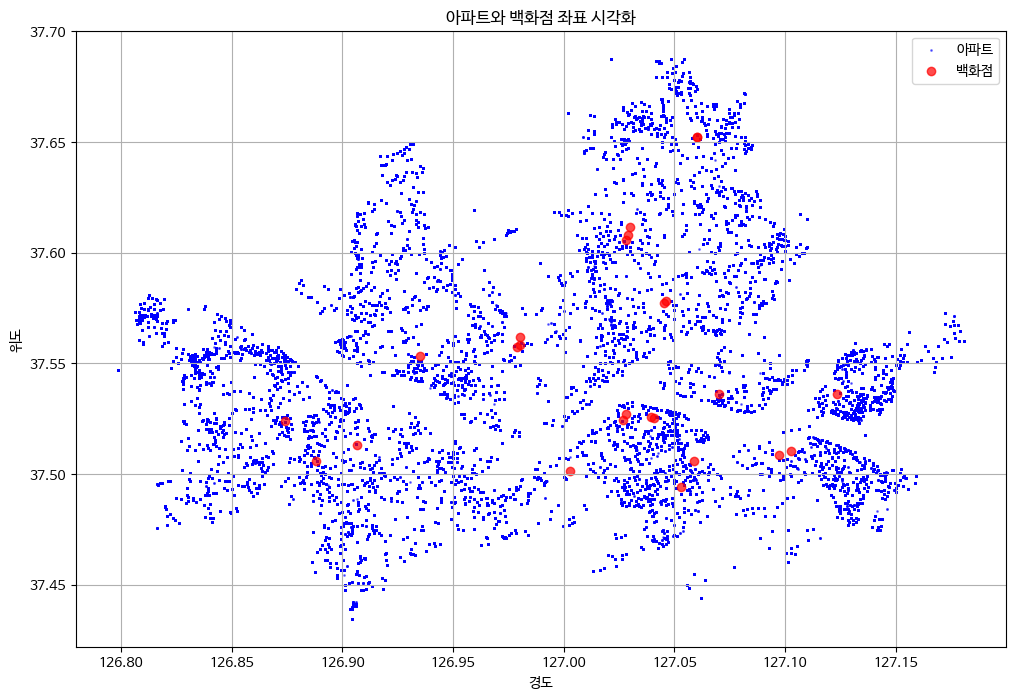

In [108]:
import matplotlib.pyplot as plt

# 아파트 좌표 추출
apartment_lat = concat['좌표Y']
apartment_lon = concat['좌표X']

# 백화점 좌표 추출
latitude = filtered_data['위도']
longitude = filtered_data['경도']

# 시각화
plt.figure(figsize=(12, 8))

# 아파트 좌표 플롯
plt.scatter(apartment_lon, apartment_lat, s=1, label='아파트', alpha=0.5, color='blue')

# A 등급 학교 좌표 플롯
plt.scatter(longitude, latitude, c='red', label='백화점', alpha=0.7)

# 제목 및 레이블
plt.title('아파트와 백화점 좌표 시각화')
plt.xlabel('경도')
plt.ylabel('위도')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()


# 저장

In [164]:
concat.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '좌표X', '좌표Y', '단지신청일', 'target', 'is_test', '근처지하철역', '지하철거리', '근처학교',
       '학교거리', '학교등급'],
      dtype='object')

In [160]:
concat.rename(columns={'등급': '학교등급'}, inplace=True)

In [162]:
delete_columns = ['근처학교수', '중학교 점수', '고등학교 점수', '학군 점수']

In [163]:
concat.drop(delete_columns, axis = 1, inplace=True)

In [165]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 57) (9272, 57)


/tmp/ipykernel_956458/1841878261.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_train.drop(['is_test'], axis = 1, inplace=True)
/tmp/ipykernel_956458/1841878261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test.drop(['is_test'], axis = 1, inplace=True)


In [166]:
dt_test.drop(columns='target', inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 57) (9272, 56)


/tmp/ipykernel_956458/3843287455.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_test.drop(columns='target', inplace=True)


In [167]:
dt_train.to_csv('./dis_train.csv', index=False)
dt_test.to_csv('./dis_test.csv', index=False)